# Лабораторная работа 2

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков Jupyter (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий, а также подкреплённый грамотной визуализацией. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета, кода и графиков. 

## Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают свою карму
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому, чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

## Прорабатываемые темы
  * Деревья
  * Лес
  * Бустинг

## Данные

Из официального блога Яндекса [известно,](https://yandex.ru/blog/company/meteum-2-0-ili-pochemu-yandeks-pogoda-sprashivaet-vas-o-dozhde) что технология предсказания погоды Метеум 2.0 опирается на Catboost.

Там же говорится, о том, что в качестве признаков используются данные от метеомоделей и дополнительные признаки, например, ```высота солнца над горизонтом``` или ```удалённость от водоёма```.




Этим летом Яндекс выложил в свободный доступ погодный датасет. В данной лабораторной работе мы будем пытаться сделать свой прогноз погоды, основываясь на этих данных.

Лицензия на данные доступна [тут](https://github.com/yandex-research/shifts#license).

### Метеомодели
Что из себя представляет прогноз метеомодели?
Фактически, это четырёхмерный тензор.
  * Две компоненты -- это широта и долгота. У каждого поставщика прогнозов свои шаги сетки по широте и долготе;
  * Вырожденное измерение, которое содержит только одно значение -- время начального состояния атмосферы, с которого будет начато физическое моделирование;
  * Последнее измерение - время, на которое сделан прогноз. Каждый поставщик таже имеет свои сетки, но обычно не чаще одного прогноза в час.
    
Для хранения таких данных был разработан формат файлов https://en.wikipedia.org/wiki/GRIB

Например, такие данные для модели GFS можно скачать с сайта https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast



### Признаки
Из первых уст про признаки можно узнать из [видео Лены Волжиной.](https://youtu.be/ECALEJ79KHg?t=578)

Их источники можно разделить на следующие группы
  * Прогноз глобальных метеомоделей. В выгруженных данных это модели CMC и GFS
    * признаки, которые начинаются с ```cmc_```
    * признаки, которые начинаются с ```gfs_```
  * Прогнозы от региональной модели WRF
    * признаки, которые начинаются с ```wrf_```
  * Климатические данные (за 40 лет наблюдений)
    * признаки, которые начинаются с ```climate_```
  * Прочие признаки
    * 'sun_elevation' -- та самая высота солнца над горизонтом.
    * 'topography_bathymetry' 
  
  
Признаки cmc имеют в своём имени 4 числа, которые кодируют физическую величину. Последнее значение -- это высота, на которой величина вычислена.

Признаки gfs и wrf имеют человеко-читаемые названия.

Еще есть технические атрибуты прогноза поставщика:
  * `_available` -- был ли доступен поставщик при прогнозе
  * ```_horizon_h``` -- каковым горизонтом для модели поставщика была временная отметка, на которую meteum рассчитвал прогноз.

  * ```_next``` -- это значение следущего прогноза данного поставщика для данной точки.

Кроме того, есть еще признаки, комбинирующие выше описанные, например
  * _grad -- это разница разница между обычным и _next прогнозом температуры.


Вот рисунок, который поможет разобраться с этими терминами:
<img src="images/object_structure.jpg">

### Целевые переменные
  * fact_temperature -- температура в данной точке (точка описывается парой координат 'fact_latitude', 'fact_longitude'  и временной отметкой 'fact_time' )
  * fact_cwsm_class -- код облачности и осадков
<img src="./images/cwsm_classes.jpg">

### Факты
  Источником истинных меток  в задачах прогнозирования погоды служат данные с метеостанций. Каждая метеостанция имеет свои географические кординаты, а также свою частоту, с которой она замеряет погоду. Некоторые метеостанции замеряют ее лишь 8 раз в день при помощи специалистов-метеорологов. Некоторые являются автоматическими и имеют большую частоту потока фактических показателей.

### Как был собран dataset
Каждое из фактических предсказаний могло быть предсказано с разными заблаговременностями.

Было составлено декартово произведение следующих множеств (см. рисунок выше)
  * (время факта, координата факта) 
  * (время составления прогноза) 
  * (самый свежий прогноз от поставщика, доступный к моменту составления прогноза на время, ближайшее ко времени факта)
    
Оно было равномерно просемлировано, чтобы его размер стал обозримым.




## Знакомство с данными

Для уменьшения количества данных, возьмем только кусок за сентябрь 2018 года

In [1]:
path_csv_2018_09 = 'data_2/train_2018_09.csv'
path_csv_2018_10 = 'data_2/train_2018_10.csv'
path_csv_2018_11 = 'data_2/train_2018_11.csv'

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_2018_09 = pd.read_csv(path_csv_2018_09)
train_2018_10 = pd.read_csv(path_csv_2018_10)
train_2018_11 = pd.read_csv(path_csv_2018_11)

In [4]:
fact_columns = [
 'fact_time',
 'fact_latitude',
 'fact_longitude',
 'fact_temperature',
 'fact_cwsm_class'
]

other_columns = [
 'topography_bathymetry',
 'sun_elevation',
]

climate_columns = [
 'climate_temperature',
 'climate_pressure',
]

climat_zone_column = 'climate'

In [5]:
cmc_columns = [
 'cmc_0_0_0_1000',
 'cmc_0_0_0_2_grad',
 'cmc_0_0_0_2_interpolated',
 'cmc_0_0_0_2_next',
 'cmc_0_0_0_2',
 'cmc_0_0_0_500',
 'cmc_0_0_0_700',
 'cmc_0_0_0_850',
 'cmc_0_0_0_925',
 'cmc_0_0_6_2',
 'cmc_0_0_7_1000',
 'cmc_0_0_7_2',
 'cmc_0_0_7_500',
 'cmc_0_0_7_700',
 'cmc_0_0_7_850',
 'cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_1_11_0',
 'cmc_0_1_65_0',
 'cmc_0_1_66_0',
 'cmc_0_1_67_0',
 'cmc_0_1_68_0',
 'cmc_0_1_7_0',
 'cmc_0_2_2_10',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_500',
 'cmc_0_2_2_700',
 'cmc_0_2_2_850',
 'cmc_0_2_2_925',
 'cmc_0_2_3_10',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'cmc_0_2_3_850',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0',
 'cmc_0_3_0_0_next',
 'cmc_0_3_1_0',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_500',
 'cmc_0_3_5_700',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'cmc_0_6_1_0',
 'cmc_available',
 'cmc_horizon_h',
 'cmc_precipitations',
 'cmc_timedelta_s',
 'cmc_0_1_65_0_grad',
 'cmc_0_1_65_0_next',
 'cmc_0_1_66_0_grad',
 'cmc_0_1_66_0_next',
 'cmc_0_1_67_0_grad',
 'cmc_0_1_67_0_next',
 'cmc_0_1_68_0_grad',
 'cmc_0_1_68_0_next', 
]

In [6]:
gfs_columns = [
 'gfs_2m_dewpoint',
 'gfs_a_vorticity',
 'gfs_available',
 'gfs_cloudness',
 'gfs_clouds_sea',
 'gfs_horizon_h',
 'gfs_humidity',
 'gfs_precipitable_water',
 'gfs_precipitations',
 'gfs_pressure',
 'gfs_r_velocity',
 'gfs_soil_temperature',
 'gfs_soil_temperature_available',
 'gfs_temperature_10000',
 'gfs_temperature_15000',
 'gfs_temperature_20000',
 'gfs_temperature_25000',
 'gfs_temperature_30000',
 'gfs_temperature_35000',
 'gfs_temperature_40000',
 'gfs_temperature_45000',
 'gfs_temperature_5000',
 'gfs_temperature_50000',
 'gfs_temperature_55000',
 'gfs_temperature_60000',
 'gfs_temperature_65000',
 'gfs_temperature_7000',
 'gfs_temperature_70000',
 'gfs_temperature_75000',
 'gfs_temperature_80000',
 'gfs_temperature_85000',
 'gfs_temperature_90000',
 'gfs_temperature_92500',
 'gfs_temperature_95000',
 'gfs_temperature_97500',
 'gfs_temperature_sea',
 'gfs_temperature_sea_grad',
 'gfs_temperature_sea_interpolated',
 'gfs_temperature_sea_next',
 'gfs_timedelta_s',
 'gfs_total_clouds_cover_high',
 'gfs_total_clouds_cover_low',
 'gfs_total_clouds_cover_middle',
 'gfs_u_wind',
 'gfs_v_wind',
 'gfs_wind_speed',
 'gfs_2m_dewpoint_grad',
 'gfs_2m_dewpoint_next',
 'gfs_total_clouds_cover_low_grad',
 'gfs_total_clouds_cover_low_next'
]

In [7]:
wrf_columns = [
 'wrf_available',
 'wrf_t2',
 'wrf_t2_next',
 'wrf_psfc',
 'wrf_rh2',
 'wrf_wind_u',
 'wrf_wind_v',
 'wrf_rain',
 'wrf_snow',
 'wrf_graupel',
 'wrf_hail',
 'wrf_t2_interpolated',
 'wrf_t2_grad',
]

Мы будем рассматривать задачи двух типов
  * Задачу регрессии предсказания температуры (колонка fact_temperature)
  * Задачу классификации -- предсказание кода облачности и осадков (колонка fact_cwsm_class)  

Рассмотрим, как метки этих задач расположены на "карте мира":

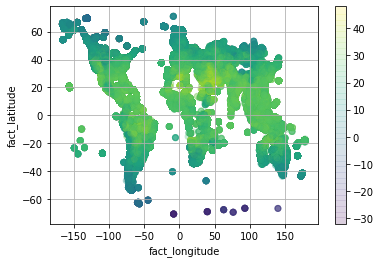

In [8]:
plt.scatter(
    train_2018_09.fact_longitude,
    train_2018_09.fact_latitude,
    c= train_2018_09.fact_temperature,
    alpha=0.1 
)
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

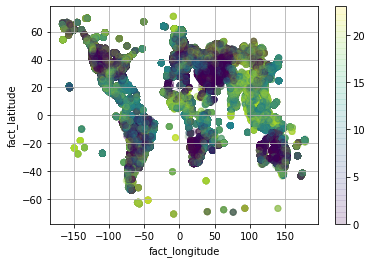

In [9]:
plt.scatter(
   train_2018_09.fact_longitude,
   train_2018_09.fact_latitude,
   c= train_2018_09.fact_cwsm_class,
   alpha=0.1 
)
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

### Задание 1. Исследование данных (1 балл)

Проведите исследовательский анализ данных.

Задача: понять взаимосвязи между откликами fact_temperature и fact_cwsm_class и признаками

---

#### Посмотрим корреляции с таргетами разных групп признаков

#### CMC признаки

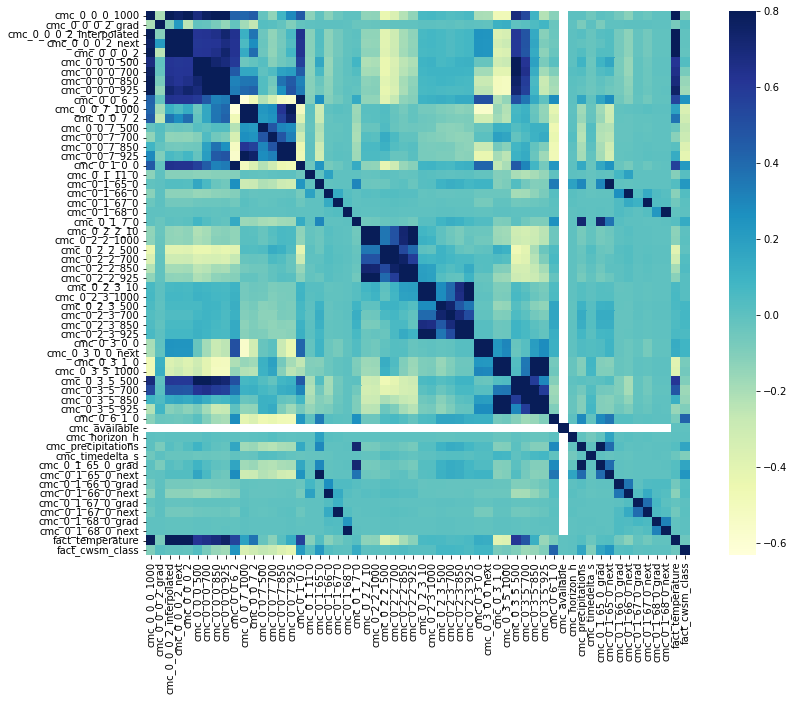

In [12]:
corrmat = train_2018_09[cmc_columns + ['fact_temperature', 'fact_cwsm_class']].corr()
f, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu", xticklabels=corrmat.index, yticklabels=corrmat.index)

#### WRF признаки

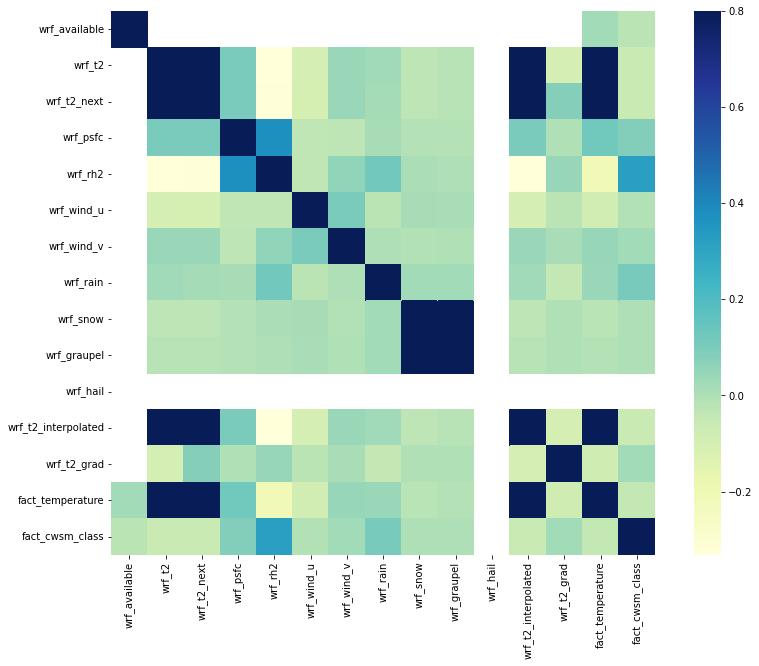

In [13]:
corrmat = train_2018_09[wrf_columns + ['fact_temperature', 'fact_cwsm_class']].corr()
f, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu", xticklabels=corrmat.index, yticklabels=corrmat.index)

#### GFS признаки

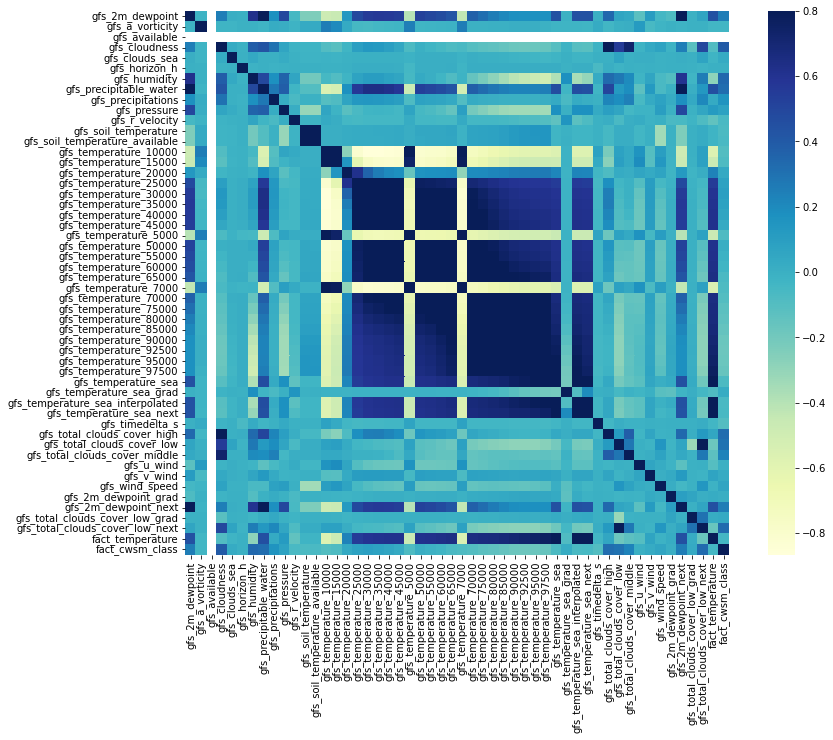

In [14]:
corrmat = train_2018_09[gfs_columns + ['fact_temperature', 'fact_cwsm_class']].corr()
f, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu", xticklabels=corrmat.index, yticklabels=corrmat.index)

#### Остальные признаки

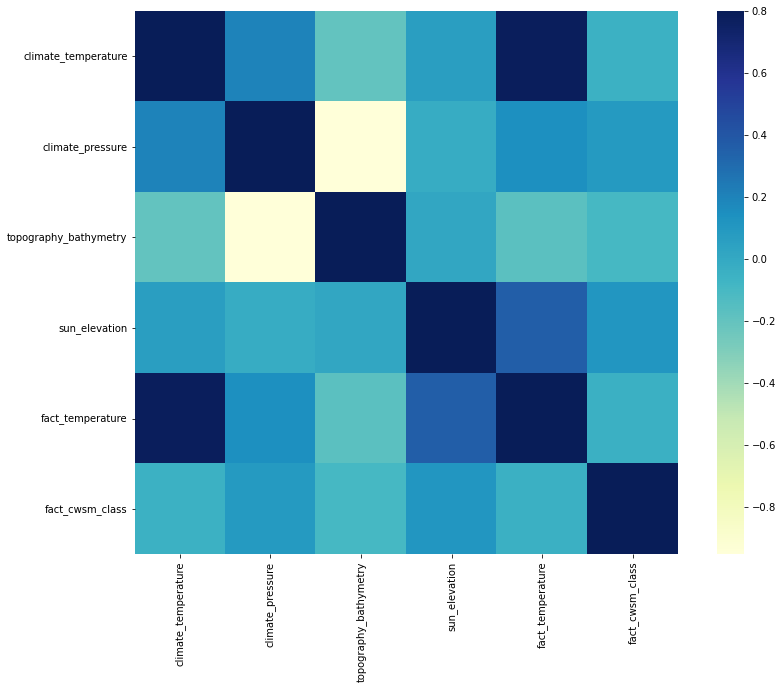

In [15]:
corrmat = train_2018_09[[climat_zone_column] + climate_columns + other_columns + ['fact_temperature', 'fact_cwsm_class']].corr()
f, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu", xticklabels=corrmat.index, yticklabels=corrmat.index)

#### Посмотрим, как разделяются облачность и осадки по признаку, например, влажность, а также по другому таргету - температуре

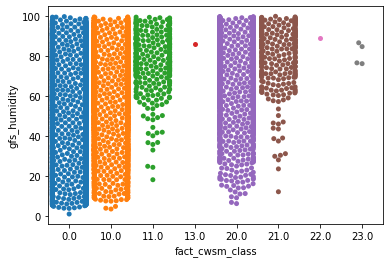

In [16]:
sns.swarmplot(x='fact_cwsm_class', 
              y='gfs_humidity', 
              data=train_2018_09.sample(10000))

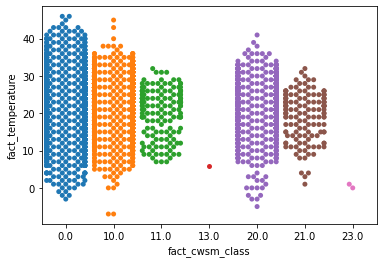

In [17]:
sns.swarmplot(x='fact_cwsm_class', 
              y='fact_temperature', 
              data=train_2018_09.sample(5000))

#### Тип климата и влажность

In [18]:
train_2018_09.groupby(['climate'])['gfs_humidity'].mean().reset_index()

,climate,gfs_humidity
0,dry,44.335012
1,mild temperate,68.768618
2,tropical,69.954581


#### Связь температуры с климатическими наблюдениями

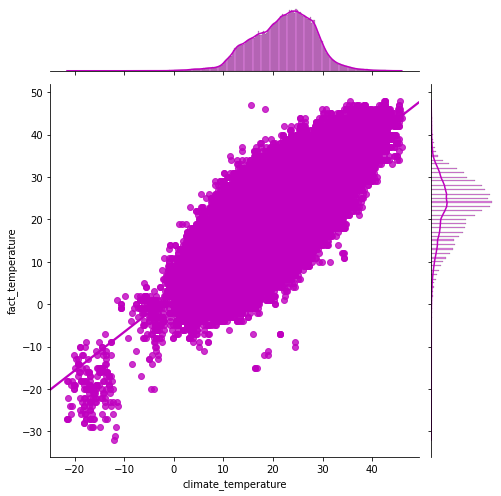

In [21]:
g = sns.jointplot(x="climate_temperature", y="fact_temperature", 
                  data=train_2018_09[["climate_temperature", "fact_temperature"]],
                  kind="reg", truncate=False,
                  color="m", height=7)

__Выводы:__

* Несколько признаков заметно положительно коррелируют с температурой (cmc_0_0_0_\*, wrf_t2_\*), ожидаемо с температурой сильно коррелярует температура gfs_temperature_\* и climate_tempareture
* С номерами классов заметной корреляции не обнаружено, что в целом логично, т.к. они не упорядочены по смыслу и имеют лишь номера
* Есть группы признаков очень схожие между собой и они, скорее всего, могут быть заменены одним или средним (cmc_0_0_0, gfs_temperature)
* Классы погоды естесственным образом связаны с признаками: при дожде (11 и 21) всегда высокая влажность, в сентябре очень редко идет снег (22 и 23), в отсутствии осадков влажность и облачность могут быть самыми разными
* Классы погоды так же тесно связаны с температурой, как минимум, снег идет только в отрицательную или около 0 температуру
* В данных присутствует природная логика, например, влажно в тропиках
* Климатические данные (за 40 лет наблюдений) являются сильным предиктором - регрессия с climate_temperature хорошо приближает fact_temperature

---

## Часть 1
Начнем с более простой задачи регрессии.

Как обычно, сначало вычислим набор тривиальных baseline решений.
Будем использовать 2 метрики качества
  * RMSE -- основная метрика
  * Долю отклонений от факта на 2 градуса -- вспомогательная метрика 

### Задание 2. Baseline решение (0.5 балла)

Построить baseline решения и вычислить метрики на периоде 2018_09:
 * климат (climate_temperature)
 * Предсказание поставщиков 
    * cmc
      * 'cmc_0_0_0_2_interpolated'
      * 'cmc_0_0_0_2_next'
      * 'cmc_0_0_0_2'
    * gfs
      * 'gfs_temperature_sea'
      * 'gfs_temperature_sea_interpolated'
      * 'gfs_temperature_sea_next'
    * wrf
      * 'wrf_t2'
      * 'wrf_t2_next'
      * 'wrf_t2_interpolated'
 * Dummy Classifier 
   * https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
     * обучать на 2018_09, тетсировать на 2018_10

---

In [22]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

def deviation_share(y_true, y_pred, threshold=0.02):
    return np.mean([x >= threshold for x in (y_pred - y_true) / y_true])

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def print_metrics(y_true, y_pred, model=''):
    model_ = '-->> ' + model if model else ''
    print(f"RMSE =".ljust(33), f'{rmse(y_true, y_pred):.2f} {model_}')
    print(f"Deviation (more than 2%) share =".ljust(33), f'{deviation_share(y_true, y_pred):.2f} {model_}')

clf = DummyRegressor()

In [23]:
features = ['cmc_0_0_0_2_interpolated', 
           'cmc_0_0_0_2_next',
           'cmc_0_0_0_2', 
           'gfs_temperature_sea',
           'gfs_temperature_sea_interpolated',
           'gfs_temperature_sea_next', 
           'wrf_t2',
           'wrf_t2_next',
           'wrf_t2_interpolated']
X_train = train_2018_09[features]
y_train = train_2018_09['climate_temperature']
X_test = train_2018_10[features]
y_test = train_2018_10['climate_temperature']

In [24]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [25]:
print_metrics(y_test, preds)

RMSE =                            7.40 
Deviation (more than 2%) share =  0.63 


---

### Задание 3. Решающее дерево (0.5 балла) 

Подобрать лучшее дерево решений на валидации. Понять, сколько в нём листов, и как долго оно обучается.
  * обучающее множество пусть будет 2018_09, а валидационное -- 2018_10

---

Заполним пропуски в признаках cmc_\*/wrf_\* средним, т.к. они распределены +-нормально с матожиданием ~290. Это пригодится при обучении моделей (препроцессинг NaN).

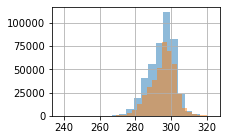

In [26]:
plt.figure(figsize=(3,2))
X_train['cmc_0_0_0_2'].hist(bins=20, alpha=0.5)
X_train['wrf_t2'].hist(bins=20, alpha=0.5)

In [27]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_ = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_ = pd.DataFrame(imp.fit_transform(X_test), columns=X_test.columns)

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

tree = DecisionTreeRegressor(random_state=42)
grid = {'min_samples_split': range(2, 6, 2), 
        'max_depth': range(2, 9, 2),
        'min_samples_leaf': range(5, 20, 5), 
        'max_leaf_nodes': range(100, 500, 100)}
tree_cv = GridSearchCV(tree,
                       param_grid=grid,
                       scoring='neg_root_mean_squared_error', 
                       cv=3, 
                       refit=True, 
                       verbose=True)

In [29]:
%%time
tree_cv.fit(X_train_, y_train)
result = tree_cv.cv_results_
tree_cv.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits
CPU times: user 6min 31s, sys: 1.54 s, total: 6min 33s
Wall time: 6min 33s


{'max_depth': 8,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [30]:
%%time
best = DecisionTreeRegressor(**tree_cv.best_params_).fit(X_train_, y_train)
print('Листьев =', best.get_n_leaves())

Листьев = 248
CPU times: user 3.64 s, sys: 4.56 ms, total: 3.65 s
Wall time: 3.65 s


In [32]:
print(f'Кол-во листьев в лучшем дереве = {best.get_n_leaves()}, время обучения = ~{4} секунды')

Кол-во листьев в лучшем дереве = 248, время обучения = ~4 секунды


In [33]:
preds_tree = tree_cv.best_estimator_.predict(X_test_)
print_metrics(y_test, preds_tree)

RMSE =                            3.57 
Deviation (more than 2%) share =  0.47 


Качество заметно улучшилось по сравнению с Dummy бейзлайн моделью: 7.40 -> 3.57 RMSE.

---

### Задание 4. Строим ансамбли (1 балл) 

Обучить случайный лес [RF] и Extremely Randomized Trees [ERT] (см. тут: https://scikit-learn.org/stable/modules/ensemble.html ) с параметрами, лучшими для одиночного дерева решений (по глубине и прочим параметрам, которые вы варьировали в прошлом задании) и сравнить с моделями Extremely Randomized Tree и случайным лесом с дефолтными параметрами.

Число деревьев в ансамбле возьмите для обоих сценариев равным 20. Замерьте время, потраченное на обучение.

---

In [34]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

rfr = RandomForestRegressor(n_estimators=20, **tree_cv.best_params_)
etr = ExtraTreesRegressor(n_estimators=20, **tree_cv.best_params_)

rfr_default = RandomForestRegressor(n_estimators=20)
etr_default = ExtraTreesRegressor(n_estimators=20)

In [35]:
%%time
rfr = rfr.fit(X_train_, y_train)

CPU times: user 49.4 s, sys: 88.2 ms, total: 49.5 s
Wall time: 49.5 s


In [36]:
%%time
etr = etr.fit(X_train_, y_train)

CPU times: user 5.75 s, sys: 46.9 ms, total: 5.8 s
Wall time: 5.8 s


In [37]:
%%time
rfr_default = rfr_default.fit(X_train_, y_train)

CPU times: user 1min 52s, sys: 467 ms, total: 1min 52s
Wall time: 1min 52s


In [38]:
%%time
etr_default = etr_default.fit(X_train_, y_train)

CPU times: user 28 s, sys: 520 ms, total: 28.6 s
Wall time: 28.6 s


In [39]:
print_metrics(y_test, rfr.predict(X_test_), 'RF')
print_metrics(y_test, etr.predict(X_test_), 'ERT')
print_metrics(y_test, rfr_default.predict(X_test_), 'RF Default')
print_metrics(y_test, etr_default.predict(X_test_), 'ERT Default')

RMSE =                            3.54 -->> RF
Deviation (more than 2%) share =  0.47 -->> RF
RMSE =                            3.58 -->> ERT
Deviation (more than 2%) share =  0.46 -->> ERT
RMSE =                            3.63 -->> RF Default
Deviation (more than 2%) share =  0.47 -->> RF Default
RMSE =                            3.63 -->> ERT Default
Deviation (more than 2%) share =  0.47 -->> ERT Default


Обе модели с базовыми параметрами обучаются заметно дольше, а качество имеют хуже.

---

### Задание 5. Квантизация признаков (1 балл) 

Давайте загрубим (квантизуем) признаки, чтобы алгоритмам построения дерева перебирать меньше порогов.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer

Еще раз обучим модели из предыдущего задания и посмотрим, насколько изменяется время.

Начинайте с более агрессивных квантизаций: т.е. сильно загрубляйте исходный признак.

---

In [40]:
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
X_train_3_bins = est.fit_transform(X_train_)
X_test_3_bins = est.transform(X_test_)

est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_train_10_bins = est.fit_transform(X_train_)
X_test_10_bins = est.transform(X_test_)

est = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')
X_train_30_bins = est.fit_transform(X_train_)
X_test_30_bins = est.transform(X_test_)

Бинов = 3

In [41]:
%%time
_ = rfr.fit(X_train_3_bins, y_train)

CPU times: user 2.95 s, sys: 14.5 ms, total: 2.96 s
Wall time: 2.96 s


In [42]:
%%time
_ = etr.fit(X_train_3_bins, y_train)

CPU times: user 3.22 s, sys: 5.54 ms, total: 3.22 s
Wall time: 3.22 s


In [43]:
%%time
_ = rfr_default.fit(X_train_3_bins, y_train)

CPU times: user 2.76 s, sys: 93.2 ms, total: 2.86 s
Wall time: 2.86 s


In [44]:
%%time
_ = etr_default.fit(X_train_3_bins, y_train)

CPU times: user 3.03 s, sys: 145 ms, total: 3.18 s
Wall time: 3.18 s


Бинов = 10

In [45]:
%%time
_ = rfr.fit(X_train_10_bins, y_train)

CPU times: user 5.34 s, sys: 51.7 ms, total: 5.39 s
Wall time: 5.39 s


In [46]:
%%time
_ = etr.fit(X_train_10_bins, y_train)

CPU times: user 4.38 s, sys: 41.7 ms, total: 4.42 s
Wall time: 4.42 s


In [47]:
%%time
_ = rfr_default.fit(X_train_10_bins, y_train)

CPU times: user 5.6 s, sys: 28.9 ms, total: 5.63 s
Wall time: 5.63 s


In [48]:
%%time
_ = etr_default.fit(X_train_10_bins, y_train)

CPU times: user 5.85 s, sys: 31.2 ms, total: 5.88 s
Wall time: 5.88 s


Бинов = 30

In [49]:
%%time
_ = rfr.fit(X_train_30_bins, y_train)

CPU times: user 8.94 s, sys: 58.7 ms, total: 9 s
Wall time: 9 s


In [50]:
%%time
_ = etr.fit(X_train_30_bins, y_train)

CPU times: user 4.91 s, sys: 31.3 ms, total: 4.95 s
Wall time: 4.94 s


In [51]:
%%time
_ = rfr_default.fit(X_train_30_bins, y_train)

CPU times: user 14.2 s, sys: 72.8 ms, total: 14.2 s
Wall time: 14.2 s


In [52]:
%%time
_ = etr_default.fit(X_train_30_bins, y_train)

CPU times: user 11.2 s, sys: 61.2 ms, total: 11.2 s
Wall time: 11.2 s


Время обучения заметно снизилось для всех моделей, вместе с ростом кол-ва бинов возрастает время обучения, что ожидаемо - дереву приходится перебирать бОльшее кол-во порогов.

---

### Задание 6 (0.5 балл) 
Катбуст умеет квантизовать признаки. Но как transformer в терминах sklearn он не функционирует.
Давайте напишем свой класс Трансформер, который будет
  * создавать cb.Pool
  * вызывать pool.quantize(border_count=32,feature_border_type="UniformAndQuantiles")  
  * сохранять pool.save_quantization_borders("borders.dat")
  * парсить этот файл, который имеет вполне прозрачную структуру
    * индекс признака, граница разбиения, возможно, указание, как быть в nan. 
  * при помощи np.digitize производить квантизацию


https://catboost.ai/en/docs/concepts/quantization

---

In [53]:
import catboost
from sklearn.base import TransformerMixin

class Transformer(TransformerMixin):
    def __init__(self, 
                 border_count=32, 
                 feature_border_type="UniformAndQuantiles"):
        self.border_count = border_count
        self.feature_border_type = feature_border_type
        
    def fit(self, X, y=None):
        self.pool = catboost.Pool(X, y)
        self.pool.quantize(border_count=self.border_count, feature_border_type=self.feature_border_type)
        self.pool.save_quantization_borders("borders.dat")
        return self
    
    def transform(self, X, y=None):
        X = X.copy(deep=True)
        if self.pool:
            borders = pd.read_csv('borders.dat', sep='\t', names=['feature_index', 'threshold'])
            features = self.pool.get_feature_names()
            for index, feature in zip(borders['feature_index'].unique(), features):
                X[feature] = np.digitize(X[feature].values, 
                                         borders.loc[borders['feature_index'] == index]['threshold'].values)
            
            return X
        else:
            raise Exception('Should be fitted before calling transform!')

In [54]:
X_train_.head(2)

,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,gfs_temperature_sea,gfs_temperature_sea_interpolated,gfs_temperature_sea_next,wrf_t2,wrf_t2_next,wrf_t2_interpolated
0,304.657772,304.565137,304.843042,32.850000,32.983341,33.050012,305.775513,305.605164,305.775513
1,295.902922,295.767383,296.173999,23.363641,22.754551,22.450006,294.964325,294.623871,294.964325


In [55]:
trans = Transformer()
trans = trans.fit(X_train_)
X_train_binned = trans.transform(X_train_)
X_train_binned.head(2)

,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,gfs_temperature_sea,gfs_temperature_sea_interpolated,gfs_temperature_sea_next,wrf_t2,wrf_t2_next,wrf_t2_interpolated
0,29,29,29,28,29,29,27,27,27
1,19,19,20,19,18,18,14,14,14


---

### Задание 7 (1 балл) 
Подберите метод квантизации (в Catboost их несколько) и число border\`ов , чтобы улучшить модели из Задания 4 (там мы учили случайные леса RF и Extremely Randomized Trees ERT ).

* Произошло ли ускорение, за счет квантизации?

* Можем ли мы позволить себе больше глубины в деревьях и число элеметнов в ансамбле? 

* На какой итерации ансамбли перестают улчшаться на валидационной выборке?

---

In [56]:
import time

quantizer_grid = {'border_count': [5, 15, 30, 50], 
                  'feature_border_type': ['Median', 
                                          'Uniform', 
                                          'UniformAndQuantiles', 
                                          'MaxLogSum', 
                                          'MinEntropy', 
                                          'GreedyLogSum']}

In [57]:
%%time
rfr = RandomForestRegressor(n_estimators=20, **tree_cv.best_params_)
etr = ExtraTreesRegressor(n_estimators=20, **tree_cv.best_params_)

for bc in quantizer_grid['border_count']:
    for fbt in quantizer_grid['feature_border_type']:
        print(f'border_count = {bc}, feature_border_type = {fbt}')
        trans = Transformer(border_count=bc, 
                            feature_border_type=fbt)
        trans = trans.fit(X_train_)
        X_train_binned = trans.transform(X_train_)
        X_test_binned = trans.transform(X_test_)

        t1 = time.time()
        rfr = rfr.fit(X_train_binned, y_train)
        etr = etr.fit(X_train_binned, y_train)
        t2 = time.time()
        
        print(f'Train time: {int(t2-t1)} seconds')
        print_metrics(y_test, rfr.predict(X_test_binned), 'RF')
        print_metrics(y_test, etr.predict(X_test_binned), 'ERT')

border_count = 5, feature_border_type = Median
Train time: 13 seconds
RMSE =                            3.94 -->> RF
Deviation (more than 2%) share =  0.49 -->> RF
RMSE =                            3.93 -->> ERT
Deviation (more than 2%) share =  0.49 -->> ERT
border_count = 5, feature_border_type = Uniform
Train time: 7 seconds
RMSE =                            3.97 -->> RF
Deviation (more than 2%) share =  0.48 -->> RF
RMSE =                            3.97 -->> ERT
Deviation (more than 2%) share =  0.48 -->> ERT
border_count = 5, feature_border_type = UniformAndQuantiles
Train time: 12 seconds
RMSE =                            3.84 -->> RF
Deviation (more than 2%) share =  0.49 -->> RF
RMSE =                            3.84 -->> ERT
Deviation (more than 2%) share =  0.48 -->> ERT
border_count = 5, feature_border_type = MaxLogSum
Train time: 13 seconds
RMSE =                            3.94 -->> RF
Deviation (more than 2%) share =  0.49 -->> RF
RMSE =                            3.93 -

С т.з. метрики RMSE один из лучших результатов показала комбинация из 50 бинов и метод UniformAndQuantiles, RF и ERT в сумме учились 16 секунд, что довольно быстро, поэтому попробуем взять, например, ERT и увеличить глубину деревьев (8 -> 15), а так же само кол-во деревьев в ансамбле (20 -> 200).

In [58]:
trans = Transformer(border_count=50, feature_border_type='UniformAndQuantiles')
trans = trans.fit(X_train_)
X_train_binned = trans.transform(X_train_)
X_test_binned = trans.transform(X_test_)

t1 = time.time()
etr = ExtraTreesRegressor(n_estimators=200, 
                          **{'max_depth': 15,
                             'max_leaf_nodes': 300,
                             'min_samples_leaf': 10,
                             'min_samples_split': 2})
etr = etr.fit(X_train_binned, y_train)
t2 = time.time()

print(f'Train time: {int(t2-t1)} seconds')
print_metrics(y_test, etr.predict(X_test_binned), 'ERT')

Train time: 87 seconds
RMSE =                            3.53 -->> ERT
Deviation (more than 2%) share =  0.47 -->> ERT


Дополнительно замерим качество на валидационной выборке в зависимости от кол-ва итераций (деревьев).

In [59]:
from tqdm import tqdm

n_trees = np.linspace(2, 150, 25)
metrics = []

for n in tqdm(n_trees):
    etr = ExtraTreesRegressor(n_estimators=int(n), 
                          **{'max_depth': 8,
                             'max_leaf_nodes': 300,
                             'min_samples_leaf': 10,
                             'min_samples_split': 2})
    etr = etr.fit(X_train_binned, y_train)
    metrics.append(mean_squared_error(y_test, etr.predict(X_test_binned), squared=False))

100%|██████████| 25/25 [10:29<00:00, 25.16s/it]


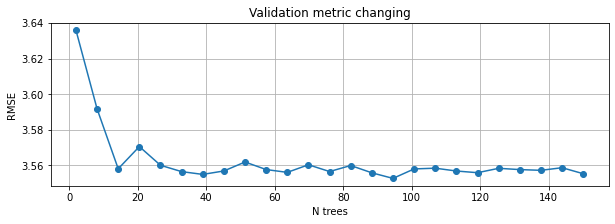

In [61]:
plt.figure(figsize=(10,3))
plt.plot(n_trees, metrics, 'o-')
plt.xlabel('N trees')
plt.ylabel('RMSE')
plt.title('Validation metric changing')
plt.grid()
plt.show()

__Выводы:__
* Произошло ускорение за счет квантизации: ранее RandomForest и ExtraTrees учились суммарно за ~50 сек, теперь за ~15 сек.

* Можно сделать больше глубину в деревьях и число элементов (деревьев/итераций) в ансамбле, качества еще немного улучшается (3.53 RMSE), а время обучения остается все еще разумным (1 мин 27 сек).

* К ~80-100 итерации ансамбль (ERT) перестает заметно улучшаться в плане качества на валидационной выборке, можно останавливать обучение

---

### Задание 8 (1 балл) 
Обучите Catboost напрямую. Какого результата удается добиться?

---

Обучим Catboost с параметрами по умолчанию на исходной выборке - без препроцессинга NaN и квантизации.

In [62]:
%%time
cbr = catboost.CatBoostRegressor(verbose=False)
cbr.fit(X_train, y_train)

print_metrics(y_test, cbr.predict(X_test), 'CatBoost default')

RMSE =                            3.48 -->> CatBoost default
Deviation (more than 2%) share =  0.46 -->> CatBoost default
CPU times: user 2min 30s, sys: 3.1 s, total: 2min 33s
Wall time: 13.7 s


Получили быстрое обучение (~14 сек) и качество лучше предыдущих (3.53 RMSE).

Попробуем эту же модель на предобработанных вручную данных:

In [65]:
%%time
cbr.fit(X_train_binned, y_train)

print_metrics(y_test, cbr.predict(X_test_binned), 'CatBoost default + preproessed + quantirized')

RMSE =                            3.54 -->> CatBoost default + preproessed + quantirized
Deviation (more than 2%) share =  0.46 -->> CatBoost default + preproessed + quantirized
CPU times: user 2min 14s, sys: 2.41 s, total: 2min 16s
Wall time: 13 s


Обучение практически такое же по скорости, качество отличается так же минимально: по RMSE чуть хуже

---

### Задание 9 (1 балл) 
Возьмите лучшие модели из заданий 4, 7 и 8
  * сравните важности принаков 
    * встроенными методами
    * при помщи пакета shap

---

Для сравнимости возьмем предобработанные данные (обработка NaN, квантизация признаков) и на одном и том наборе данных обучим 3 лучшие модели.

In [66]:
%%time
best_4 = RandomForestRegressor(n_estimators=20, **tree_cv.best_params_)
best_7 = ExtraTreesRegressor(n_estimators=200, 
                          **{'max_depth': 15,
                             'max_leaf_nodes': 300,
                             'min_samples_leaf': 5,
                             'min_samples_split': 2})
best_8 = catboost.CatBoostRegressor(verbose=False)

best_4 = best_4.fit(X_train_binned, y_train)
best_7 = best_7.fit(X_train_binned, y_train)
best_8 = best_8.fit(X_train_binned, y_train)

CPU times: user 3min 31s, sys: 2.36 s, total: 3min 34s
Wall time: 1min 33s


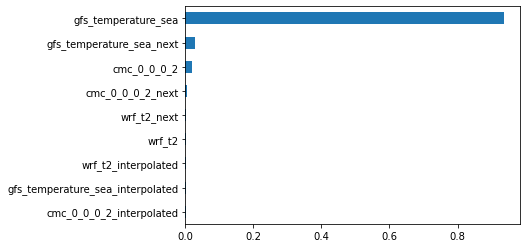

In [67]:
pd.Series(best_4.feature_importances_, index=X_train_binned.columns).nlargest(10)[::-1].plot(kind='barh')

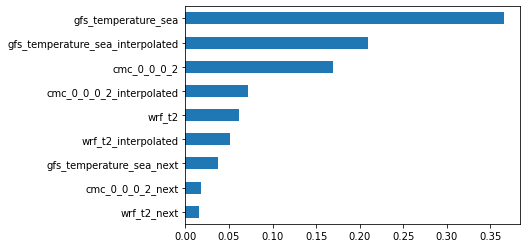

In [68]:
pd.Series(best_7.feature_importances_, index=X_train_binned.columns).nlargest(10)[::-1].plot(kind='barh')

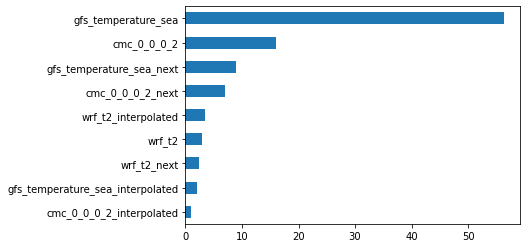

In [69]:
pd.Series(best_8.feature_importances_, index=X_train_binned.columns).nlargest(10)[::-1].plot(kind='barh')

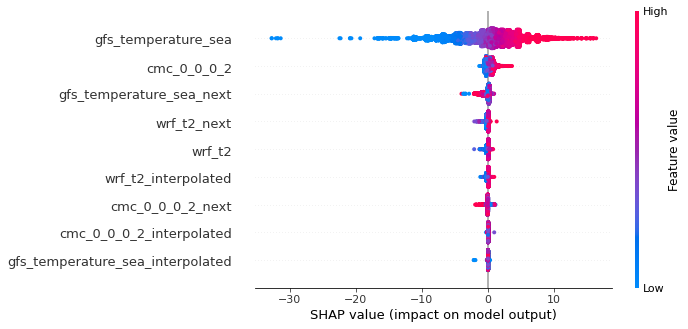

In [70]:
import shap

X_train_sample = X_train_binned.sample(10000) # для уменьшения времени расчета shap_values
shap.summary_plot(shap.Explainer(best_4)(X_train_sample))

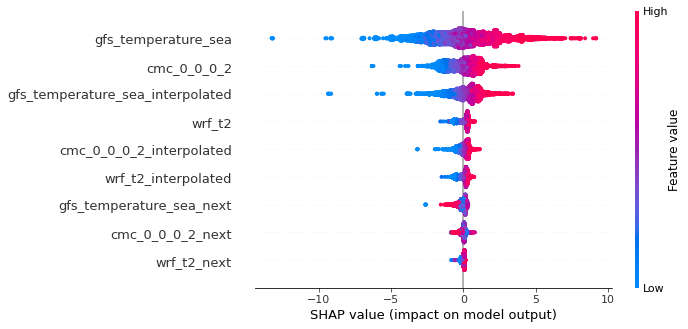

In [71]:
shap.summary_plot(shap.Explainer(best_7)(X_train_sample))

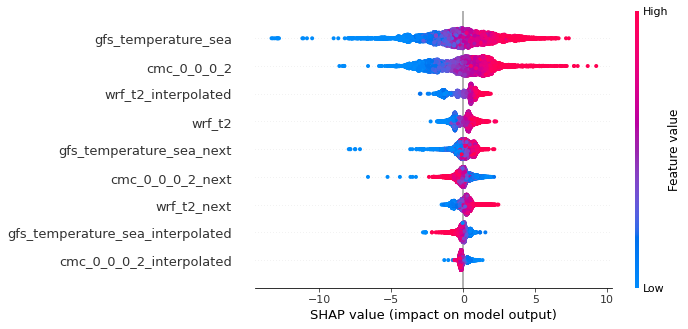

In [72]:
shap.summary_plot(shap.Explainer(best_8)(X_train_sample))

__Выводы:__
* Встроенные методы оценки важности признаков (на основе уменьшения нечистоты при сплитах) показывают, какие признаки больше всего участвовали в модели и внесли наибольший вклад, но влияние разных значений признака на выход модели не понятен
* SHAP показывает, как малые/большие значения вещественных признаков влияют на выход модели - работают в плюс или минус (увеличивают или уменьшают прогнозируемую температуру)
* По SHAP видим, со многими признаками связь монотонная и это логично, например, gfs_temperature_sea - прогноз температуры поставщиками, мы ожидаемо с ними близки будем

---

### Задание 10 (0.5 балл) 
В ролике Лена упоминала про ускорение за счет обучения моделей на разных географических регионах. 
Как первое приближение индикатора принадлежности к тому или иному региону попробуйте использовать имеющуюся категориальную переменную climate.

Удалось ли за счет этого увеличить качество?
Можно ли придумать что-то лучшее, чем разбиение по climate?

---

Сравним качество Catboost без и с признаком climate, сравним качество:

In [73]:
%%time
X_train_climate = pd.concat([X_train, train_2018_09['climate']], axis=1)
X_test_climate = pd.concat([X_test, train_2018_10['climate']], axis=1)

cbr = catboost.CatBoostRegressor(verbose=False)

print('Без climate')
train_dataset = catboost.Pool(data=X_train,
                              label=y_train)
eval_dataset = catboost.Pool(data=X_test,
                             label=y_test)
cbr.fit(train_dataset)
print_metrics(y_test, cbr.predict(eval_dataset), 'CatBoost default')

print('С climate')
train_dataset = catboost.Pool(data=X_train_climate,
                              label=y_train,
                              cat_features=['climate'])
eval_dataset = catboost.Pool(data=X_test_climate,
                             label=y_test,
                             cat_features=['climate'])
cbr.fit(train_dataset)
print_metrics(y_test, cbr.predict(X_test_climate), 'CatBoost default + climate feature')

Без climate
RMSE =                            3.48 -->> CatBoost default
Deviation (more than 2%) share =  0.46 -->> CatBoost default
С climate
RMSE =                            3.40 -->> CatBoost default + climate feature
Deviation (more than 2%) share =  0.48 -->> CatBoost default + climate feature
CPU times: user 8min 30s, sys: 17.7 s, total: 8min 48s
Wall time: 57.8 s


__Выводы:__
* Качество увеличилось (RMSE уменьшилась с 3.48 до 3.40) благодаря добавлению climate, как категориальной фичи.
* Дополнительно можно принимать во внимание иные признаки и сведения о географии - виды климата, широта/долгота, близость к мегаполисам/океану/горам/и т.д. Плюс можно в принципе учить отдельные модели под каждый регион, это тоже может улучшить качество.

---

## Часть 2
Давайте теперь поставим задачу классификации.

<img src="./images/cwsm_classes.jpg" width="500">

In [74]:
train_2018_09.fact_cwsm_class.value_counts(dropna=False)

0.0     175257
10.0    148256
20.0     81576
11.0     13115
21.0     12004
23.0       170
13.0        36
22.0        16
12.0         6
Name: fact_cwsm_class, dtype: int64

In [75]:
(train_2018_09.fact_cwsm_class.astype("int8").isin([0,10,20])).value_counts(normalize=True)

True     0.941113
False    0.058887
Name: fact_cwsm_class, dtype: float64

In [76]:
0.941113 / 0.058887

15.981676770764345

In [77]:
(train_2018_10.fact_cwsm_class.astype("int8").isin([0,10,20])).value_counts(normalize=True)

True     0.93364
False    0.06636
Name: fact_cwsm_class, dtype: float64

Видно, что по объектам шанс 1 к 16, что будет дождь.

Сначала будем решать задачу бинарной классификации

Как будем оценивать эту задачу?
Раз у нас классы не сбалансированы, то, согласно, например https://ysda_trove.gitlab.io/ml-handbook/chapters/model_evaluation/intro, 
метрика accuracy/error_rate нам не подойдёт.

Давайте будем рассматривать
  * сбалансированную точность как основную метрику качества
  * Как вспомогательные
    * точность предсказания класса 1
    * полноту предсказания класса 1
    * F1-меру
  
Для начала порог отсечения при принятии решения к какому классу относится предскзаание будем брать 0.5

### Задание 11 (0.5 балла) 
 
Постройте baseline решения:
  
* Dummy Classifier 

* дерево решений

По валидационной выборке подберите лучшие параметры
    

---

In [78]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

def print_metrics_class(y_true, y_pred, model=''):
    model_ = '-->> ' + model if model else ''
    print(f"Balanced accuracy =".ljust(19), f'{balanced_accuracy_score(y_true, y_pred):.3f} {model_}')
    print(f"Precision =".ljust(19), f'{precision_score(y_true, y_pred):.3f} {model_}')
    print(f"Recall =".ljust(19), f'{recall_score(y_true, y_pred):.3f} {model_}')
    print(f"F1-score =".ljust(19), f'{f1_score(y_true, y_pred):.3f} {model_}')
    
y_train_class = (~train_2018_09['fact_cwsm_class'].astype("int8").isin([0,10,20])).astype(int)
y_test_class = (~train_2018_10['fact_cwsm_class'].astype("int8").isin([0,10,20])).astype(int)

print(f'{y_train_class.mean():.3f}', f'{y_test_class.mean():.3f}')

0.059 0.066


In [82]:
clf = DummyClassifier()
clf = clf.fit(X_train_, y_train_class)

print_metrics_class(y_test_class, clf.predict(X_test_))

Balanced accuracy = 0.500 
Precision =         0.000 
Recall =            0.000 
F1-score =          0.000 


In [84]:
tree_clf = DecisionTreeClassifier(random_state=42)
grid = {'min_samples_split': [2, 10], 
        'max_depth': [3, 5, None],
        'min_samples_leaf': [2, 10], 
        'max_leaf_nodes': [100, 500, None], 
        'class_weight': ['balanced', None]}
tree_cv_clf = GridSearchCV(tree_clf,
                           param_grid=grid,
                           scoring='balanced_accuracy', 
                           cv=3, 
                           refit=True, 
                           verbose=True)

In [87]:
%%time
tree_cv_clf.fit(X_train_, y_train_class)
result = tree_cv_clf.cv_results_
tree_cv_clf.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
CPU times: user 8min 38s, sys: 3.36 s, total: 8min 41s
Wall time: 8min 42s


{'class_weight': 'balanced',
 'max_depth': None,
 'max_leaf_nodes': 500,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [88]:
preds_tree_clf = tree_cv_clf.best_estimator_.predict(X_test_)
print_metrics_class(y_test_class, preds_tree_clf)

Balanced accuracy = 0.625 
Precision =         0.100 
Recall =            0.691 
F1-score =          0.175 


---

### Задание 12 (2.5 балла) 
  * обучите RF-ERT на оригинальных признаках
  * обучите RF-ERT поверх квантизации, которая была лучшей в задачи регрессии
  * обучите catboost
  * сравните качество по рассмотренным ранее метрикам (основной и дополнительным)
  * сравните важности принаков 
    * встроенными методами
    * при помщи пакета shap

---

In [89]:
%%time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rfr = RandomForestClassifier(n_estimators=20, **tree_cv_clf.best_params_)
etr = ExtraTreesClassifier(n_estimators=20, **tree_cv_clf.best_params_)
rfr = rfr.fit(X_train_, y_train_class)
etr = etr.fit(X_train_, y_train_class)
print_metrics_class(y_test_class, rfr.predict(X_test_), 'RF')
print_metrics_class(y_test_class, etr.predict(X_test_), 'ERT')

Balanced accuracy = 0.640 -->> RF
Precision =         0.109 -->> RF
Recall =            0.664 -->> RF
F1-score =          0.188 -->> RF
Balanced accuracy = 0.632 -->> ERT
Precision =         0.099 -->> ERT
Recall =            0.745 -->> ERT
F1-score =          0.175 -->> ERT
CPU times: user 44.5 s, sys: 209 ms, total: 44.8 s
Wall time: 44.8 s


In [90]:
%%time
rfr_quant = RandomForestClassifier(n_estimators=20, **tree_cv_clf.best_params_)
etr_quant = ExtraTreesClassifier(n_estimators=20, **tree_cv_clf.best_params_)
trans = Transformer(border_count=50, feature_border_type='UniformAndQuantiles')
trans = trans.fit(X_train_)
X_train_binned = trans.transform(X_train_)
X_test_binned = trans.transform(X_test_)

rfr_quant = rfr_quant.fit(X_train_binned, y_train_class)
etr_quant = etr_quant.fit(X_train_binned, y_train_class)
print_metrics_class(y_test_class, rfr_quant.predict(X_test_binned), 'RF + quantirized')
print_metrics_class(y_test_class, etr_quant.predict(X_test_binned), 'ERT + quantirized')

Balanced accuracy = 0.636 -->> RF + quantirized
Precision =         0.105 -->> RF + quantirized
Recall =            0.686 -->> RF + quantirized
F1-score =          0.183 -->> RF + quantirized
Balanced accuracy = 0.632 -->> ERT + quantirized
Precision =         0.098 -->> ERT + quantirized
Recall =            0.757 -->> ERT + quantirized
F1-score =          0.174 -->> ERT + quantirized
CPU times: user 20 s, sys: 435 ms, total: 20.4 s
Wall time: 20.1 s


In [91]:
%%time
cbr_clf = catboost.CatBoostClassifier(verbose=False, auto_class_weights='Balanced')
cbr_clf.fit(X_train, y_train_class)

print_metrics_class(y_test_class, cbr_clf.predict(X_test), 'CatBoost default')

Balanced accuracy = 0.645 -->> CatBoost default
Precision =         0.110 -->> CatBoost default
Recall =            0.680 -->> CatBoost default
F1-score =          0.190 -->> CatBoost default
CPU times: user 3min 35s, sys: 4.34 s, total: 3min 39s
Wall time: 22.5 s


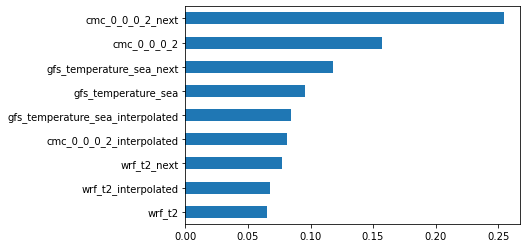

In [92]:
pd.Series(rfr.feature_importances_, index=X_train.columns).nlargest(10)[::-1].plot(kind='barh')

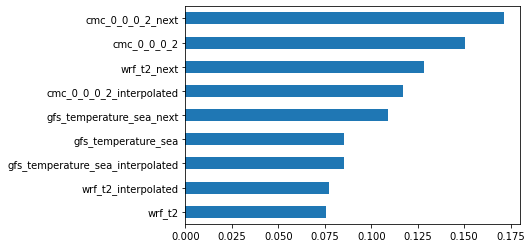

In [93]:
pd.Series(etr.feature_importances_, index=X_train.columns).nlargest(10)[::-1].plot(kind='barh')

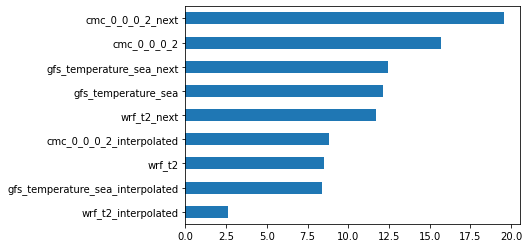

In [94]:
pd.Series(cbr_clf.feature_importances_, index=X_train.columns).nlargest(10)[::-1].plot(kind='barh')

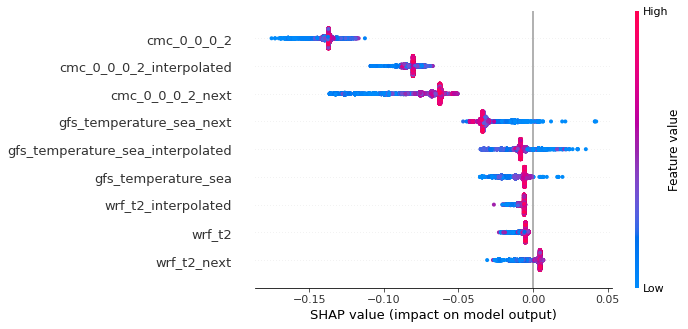

In [95]:
X_train_sample = X_train_binned.sample(10000) # для уменьшения времени расчета shap_values
shap.summary_plot(shap.Explainer(rfr)(X_train_sample)[:,:,1])

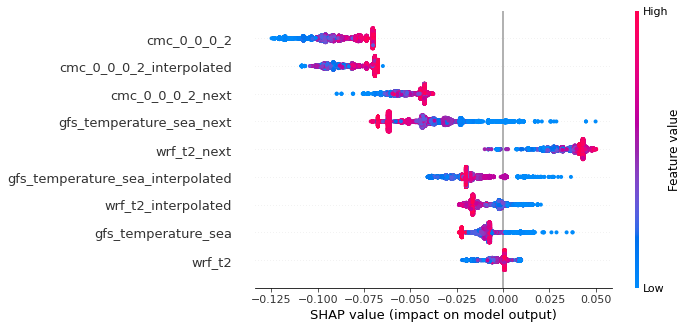

In [96]:
shap.summary_plot(shap.Explainer(etr)(X_train_sample)[:,:,1])

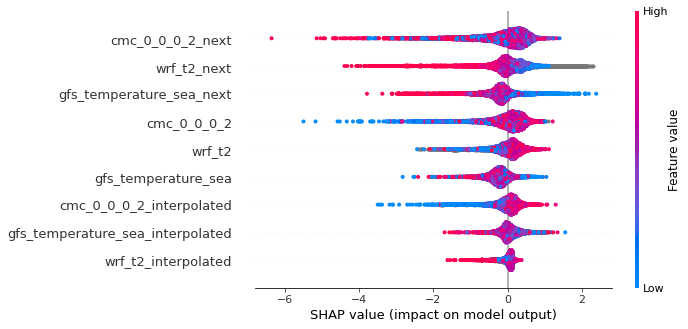

In [97]:
X_train_sample_ = X_train.sample(10000) # для уменьшения времени расчета shap_values
shap.summary_plot(shap.Explainer(cbr_clf)(X_train_sample_))

__Выводы:__
* Сравнение качества
    * Квантизация все так же ускоряет обучение, при этом созраняет качество примерно на том же уровне
    * Catboost имеет лучшее качество по Balanced accuracy, Precision и F1, но Recall заметно лучше был у комбинации ERT + quantirized 
* Важность признаков
    * В отличие от прогноза температуры, в топе теперь признаки cmc_..., но gfs_temperature тоже важна
    * SHAP показывает тоже в целом разумные зависимости, например, низкая температуры повышает вероятность осадков (дождь/снег) и наоборот

---

### Задание 13. "Протухание модели" (0.5 балла) 
  
  Давайте узнаем, происходит ли устаревание ("протухание") модели. 
    
  Расмотрите, как модели из регрессионной и классификационной задач предсказывают на 2018_11, 2018_12 и 2019_01.
  
  Происходит ли деградация?

---

In [98]:
train_2018_11 = pd.read_csv('data_2/train_2018_11.csv')
train_2018_12 = pd.read_csv('data_2/train_2018_12.csv')
train_2019_01 = pd.read_csv('data_2/train_2019_01.csv')

Регрессия

In [99]:
cbr_rot = catboost.CatBoostRegressor(verbose=False)
cbr_rot.fit(X_train, y_train)  # обучение на 2018-09

print_metrics(y_test, cbr_rot.predict(X_test)) # прогноз на 2018-10

RMSE =                            3.48 
Deviation (more than 2%) share =  0.46 


In [100]:
for data in [train_2018_11, train_2018_12, train_2019_01]:
    X_test_now = data[features]
    y_test_now = data['fact_temperature']
    print_metrics(y_test_now, cbr_rot.predict(X_test_now))

RMSE =                            4.46 
Deviation (more than 2%) share =  0.59 
RMSE =                            5.12 
Deviation (more than 2%) share =  0.61 
RMSE =                            5.53 
Deviation (more than 2%) share =  0.58 


Классификация

In [101]:
cbr_clf_rot = catboost.CatBoostClassifier(verbose=False, auto_class_weights='Balanced')
cbr_clf_rot.fit(X_train, y_train_class)  # обучение на 2018-09

print_metrics_class(y_test_class, cbr_clf_rot.predict(X_test)) # прогноз на 2018-10

Balanced accuracy = 0.645 
Precision =         0.110 
Recall =            0.680 
F1-score =          0.190 


In [102]:
for data in [train_2018_11, train_2018_12, train_2019_01]:
    X_test_now = data[features]
    y_test_now = (~data['fact_cwsm_class'].astype("int8").isin([0,10,20])).astype(int)
    print_metrics_class(y_test_now, cbr_clf_rot.predict(X_test_now))

Balanced accuracy = 0.631 
Precision =         0.123 
Recall =            0.703 
F1-score =          0.209 
Balanced accuracy = 0.635 
Precision =         0.137 
Recall =            0.750 
F1-score =          0.232 
Balanced accuracy = 0.624 
Precision =         0.124 
Recall =            0.753 
F1-score =          0.213 


__Выводы:__
* Регрессия
    * Да, протухание наблюдается, прогнозы на более поздние периоды все менее точные, RMSE растет: 3.48 -> 4.46 -> 5.12-> 5.53 
* Классификация
    * Да, протухание также наблюдается, Balanced accuracy падает (хоть и не строго монотонно): 0.645 -> 0.631 -> 0.635 -> 0.624 

---

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. В этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

### Задание 14 (0.5 балла) 
  Вспомним, что мы не подбирали порог, по которому классификаторы превращают оценку вероятности принадлежности к первому классу 
  
  Давайте оценим, насколько хорошо калиброваны наши классификаторы из Задания 12 на 2018_11
  
    
  ссылка на главу учебника
https://ysda_trove.gitlab.io/ml-handbook/chapters/prob_ML/calibration

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

https://dyakonov.org/2020/03/27/проблема-калибровки-уверенности/

---

In [103]:
cbr_clf = catboost.CatBoostClassifier(verbose=False, auto_class_weights='Balanced')
cbr_clf.fit(X_train, y_train_class)  # обучение на 2018-09

X_calibrate = train_2018_11[features]
X_calibrate = pd.DataFrame(imp.fit_transform(X_calibrate), columns=X_calibrate.columns)
y_calibrate = (~train_2018_11['fact_cwsm_class'].astype("int8").isin([0,10,20])).astype(int)

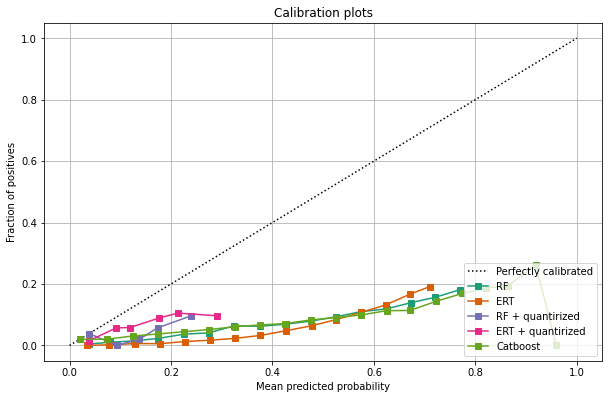

In [104]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

def plot_calibrations(clf_list, X_calibrate, y_calibrate):
    fig = plt.figure(figsize=(10, 13))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}

    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
                clf,
                X_calibrate,
                y_calibrate,
                n_bins=20,
                name=name,
                ax=ax_calibration_curve,
                color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    
clf_list = [
    (rfr, "RF"),
    (etr, "ERT"),
    (rfr_quant, "RF + quantirized"),
    (etr_quant, "ERT + quantirized"),
    (cbr_clf, "Catboost")
]

plot_calibrations(clf_list, X_calibrate, y_calibrate)

Классификаторы некалиброваны, выходы модели нельзя интерпретировать, как вероятности, нужна калибровка.

---

### Задание 15 (1 балл) 

Давайте откалибруем классификаторы из задания 12 на 2018_10 и вновь посмотрим на качество их калибровки на 2018_11.

Построим кривые точность-полнота для класса 1 и класса 0 у некалиброванных и калиброванных моделей. Отличаются ли они?

---

In [105]:
X_for_calibration = train_2018_10[features]
X_for_calibration = pd.DataFrame(imp.fit_transform(X_for_calibration), columns=X_for_calibration.columns)
y_for_calibration = (~train_2018_10['fact_cwsm_class'].astype("int8").isin([0,10,20])).astype(int)

In [106]:
from sklearn.calibration import CalibratedClassifierCV

clf_list_calibrated = [(CalibratedClassifierCV(base_estimator=model[0], 
                                               cv="prefit").fit(X_for_calibration, y_for_calibration), 
                        model[1]) for model in clf_list]

(0.0, 0.3)

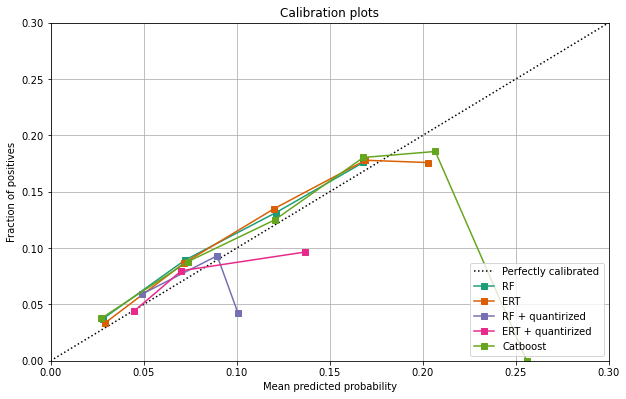

In [107]:
plot_calibrations(clf_list_calibrated, X_calibrate, y_calibrate)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)

Качество калибровки улучшилось. Так как класс "1" очень редкий, высокие вероятности мы не будем давать в прогнозах, как и ожидалось.

Посмотрим, как изменилось распределение вероятностей в прогнозе:

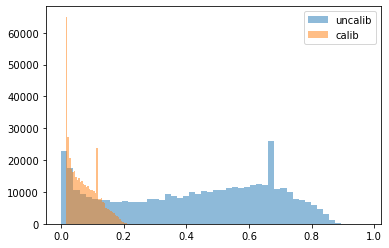

In [108]:
cbr_clf_calib = CalibratedClassifierCV(base_estimator=cbr_clf, cv="prefit").fit(X_for_calibration, y_for_calibration)

uncalib_preds = cbr_clf.predict_proba(X_calibrate)[:, 1]
calib_preds = cbr_clf_calib.predict_proba(X_calibrate)[:, 1]

plt.hist(uncalib_preds, alpha=0.5, bins=50, label='uncalib')
plt.hist(calib_preds, alpha=0.5, bins=50, label='calib')
plt.legend()
plt.show()

Построим графики Recall/Precision в зависимости от порога для калиброванной и не калиброванной моделей:

In [109]:
thresholds = np.linspace(0.01, .99, 21)

precision_uncalib = [precision_score(y_calibrate, [int(p > thr) for p in uncalib_preds]) for thr in thresholds]
recall_uncalib = [recall_score(y_calibrate, [int(p > thr) for p in uncalib_preds]) for thr in thresholds]

precision_calib = [precision_score(y_calibrate, [int(p > thr) for p in calib_preds]) for thr in thresholds]
recall_calib = [recall_score(y_calibrate, [int(p > thr) for p in calib_preds]) for thr in thresholds]

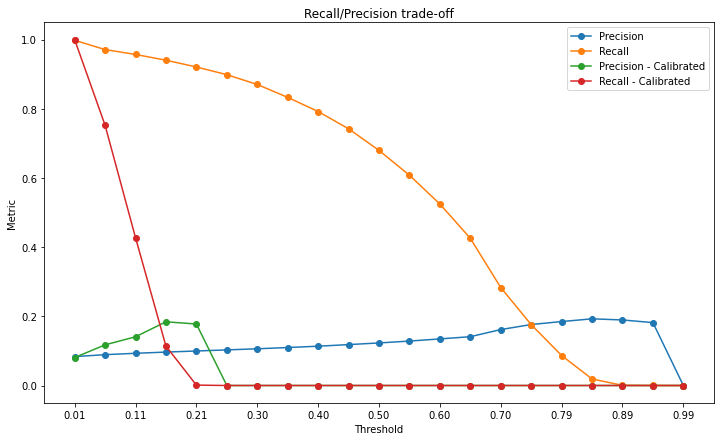

In [110]:
plt.figure(figsize=(12, 7))
plt.plot(precision_uncalib, 'o-', label='Precision')
plt.plot(recall_uncalib, 'o-',  label='Recall')
plt.plot(precision_calib, 'o-', label='Precision - Calibrated')
plt.plot(recall_calib, 'o-',  label='Recall - Calibrated')
plt.xticks(range(0, len(thresholds), 2), list(map(lambda x: f'{x:.2f}', thresholds))[::2])
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Recall/Precision trade-off')
plt.legend()
plt.show()

Распределение прогнозируемых вероятностей существенно поменялось и как следствие изменился график Precision/Recall: у калиброванной модели вероятности и чувствительные пороги сосредоточены в малых диапазонах вероянтностей (0-0.3).

---

Мы попробовали два типа ансамблей: случайный лес (бэггинг) и градиентный бустинг. Время что-нибудь настекать!


Описание того, как строить ансамбли типа стекинг можно найти по слудующим ссылкам
  * На лекции https://lk.yandexdataschool.ru/courses/2021-autumn/7.936-machine-learning-1/classes/7718/
  * В учебнике https://ysda_trove.gitlab.io/ml-handbook/chapters/ensembles/intro#стекинг
  * В статье https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/

### Задание 16 (2 балла) 
    
  Какие базовые модели можно использовать:
    * лучшие модели из задания 12
    * давайте обучим логистическую регрессию
    * по желанию, попробуйте нейросеть
    
  Попробуйте брать 2-3 разные базовые модели первого уровня, а в качестве модели второго уровня пропробуйте ERT и catboost.
    
  Весь ансабль должен быть обучен на 2018_09, т.е. нужно применять cross_val_predict.  
  Почему так следует делать, можно вспомнить, заглянув в соответствующий раздел учебника  
  https://ysda_trove.gitlab.io/ml-handbook/chapters/ensembles/intro

---

Реализуем стекинг из базовых моделей Random Forest, Logistic Regression и Multi-layer Perceptron, а в качестве модели второго уровня попробуем 2 варианта - ERT и Catboost.

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict

params = {'class_weight': 'balanced',
         'max_depth': None,
         'max_leaf_nodes': 500,
         'min_samples_leaf': 2,
         'min_samples_split': 2}

rf = RandomForestClassifier(n_estimators=20, **params)
logreg = LogisticRegression()
mlp = MLPClassifier()
ert = ExtraTreesClassifier(n_estimators=20, **params)
catb = catboost.CatBoostClassifier(verbose=False, auto_class_weights='Balanced')

In [112]:
%%time
rf_preds = cross_val_predict(estimator=rf, X=X_train_, y=y_train_class, cv=5, method='predict_proba')
rf_preds_test = cross_val_predict(estimator=rf, X=X_test_, y=y_test_class, cv=5, method='predict_proba')

CPU times: user 4min 50s, sys: 925 ms, total: 4min 51s
Wall time: 4min 51s


In [113]:
%%time
logreg_preds = cross_val_predict(estimator=logreg, X=X_train_, y=y_train_class, cv=5, method='predict_proba')
logreg_preds_test = cross_val_predict(estimator=logreg, X=X_test_, y=y_test_class, cv=5, method='predict_proba')

CPU times: user 1min 36s, sys: 1.31 s, total: 1min 37s
Wall time: 12.5 s


In [114]:
%%time
mlp_preds = cross_val_predict(estimator=mlp, X=X_train_, y=y_train_class, cv=3, method='predict_proba')
mlp_preds_test = cross_val_predict(estimator=mlp, X=X_test_, y=y_test_class, cv=3, method='predict_proba')

CPU times: user 1h 23min 45s, sys: 30.4 s, total: 1h 24min 15s
Wall time: 10min 34s


In [115]:
X_train_stacking = pd.concat([pd.Series(rf_preds[:,1]), 
                              pd.Series(logreg_preds[:,1]),
                              pd.Series(mlp_preds[:,1])], 
                             axis=1)
X_test_stacking  = pd.concat([pd.Series(rf_preds_test[:,1]), 
                              pd.Series(logreg_preds_test[:,1]),
                              pd.Series(mlp_preds_test[:,1])], 
                             axis=1)
X_train_stacking.columns = ['rf', 'logreg', 'mlp']
X_test_stacking.columns = ['rf', 'logreg', 'mlp']

In [116]:
X_train_stacking.mean()

rf        0.400541
logreg    0.058943
mlp       0.067359
dtype: float64

In [117]:
X_test_stacking.mean()

rf        0.408740
logreg    0.066431
mlp       0.061726
dtype: float64

In [118]:
ert.fit(X_train_stacking, y_train_class)
print_metrics_class(y_test_class, ert.predict(X_test_stacking), 'ERT')

Balanced accuracy = 0.654 -->> ERT
Precision =         0.108 -->> ERT
Recall =            0.744 -->> ERT
F1-score =          0.189 -->> ERT


У ERT отдельности было:
* Balanced accuracy = 0.630 -->> ERT
* Precision =         0.099 -->> ERT
* Recall =            0.736 -->> ERT
* F1-score =          0.175 -->> ERT

In [119]:
catb.fit(X_train_stacking, y_train_class)
print_metrics_class(y_test_class, catb.predict(X_test_stacking), 'CatBoost')

Balanced accuracy = 0.634 -->> CatBoost
Precision =         0.113 -->> CatBoost
Recall =            0.604 -->> CatBoost
F1-score =          0.191 -->> CatBoost


У Catboost отдельности было:
* Balanced accuracy = 0.645 -->> CatBoost default
* Precision =         0.110 -->> CatBoost default
* Recall =            0.680 -->> CatBoost default
* F1-score =          0.190 -->> CatBoost default

__Выводы:__
* Получили заметный прирост качества при использовании ERT на втором уровне, прирост по всем метрикам. 
* У Catboost качество особо не изменилось: Precision/F1-score подросли, Balanced accuracy/Recall упали.

---